In [1]:
#| default_exp datasets

In [9]:
import sys
sys.path.insert(1, '/home/umangkaushik/projects/my_fastai_part2')

In [10]:
#| export
from __future__ import annotations
import math, numpy as np, matplotlib.pyplot as plt
from operator import itemgetter
from itertools import zip_longest
import fastcore.all as fc

from torch.utils.data import default_collate
from miniai.training import *

In [11]:
import logging, pickle, gzip, os, time, shutil, torch, matplotlib as mpl
from pathlib import Path

from torch import tensor, nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from datasets import load_dataset, load_dataset_builder

import torchvision.transforms.functional as TF
from fastcore.test import test_close

In [12]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['image.cmap'] = 'gray'

In [13]:
logging.disable(logging.WARNING)

`logging.disable(logging.WARNING)`
- it is used to disable logging of warning messages
- it prevents warning messages from being displayed in the console or written to log files.

## Hugging Face Datasets

In [14]:
name = 'fashion_mnist'
ds_builder = load_dataset_builder(name)
print(ds_builder.info.description)

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of
60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image,
associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in
replacement for the original MNIST dataset for benchmarking machine learning algorithms.
It shares the same image size and structure of training and testing splits.



`load_dataset_builder` is used to load a dataset builder and inspects the general info that is required to build a dataset without downloading the dataset itself.

In [15]:
ds_builder.info.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(num_classes=10, names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [16]:
ds_builder.info.splits

{'train': SplitInfo(name='train', num_bytes=31296655, num_examples=60000, dataset_name='fashion_mnist'),
 'test': SplitInfo(name='test', num_bytes=5233818, num_examples=10000, dataset_name='fashion_mnist')}

In [17]:
dsd = load_dataset(name)

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /home/umangkaushik/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [18]:
dsd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [19]:
train, test = dsd['train'], dsd['test']
train[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

In [20]:
x, y = ds_builder.info.features

In [21]:
x, y

('image', 'label')

In [22]:
x, y = 'image', 'label'
img = train[0][x]
img

In [23]:
xb = train[:5][x]
yb = train[:5][y]

In [24]:
featy = train.features[y]
featy

ClassLabel(num_classes=10, names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)

In [26]:
yb

[9, 0, 0, 3, 0]

In [25]:
featy.int2str(yb)

['Ankle boot',
 'T - shirt / top',
 'T - shirt / top',
 'Dress',
 'T - shirt / top']

In [27]:
def collate_fn(b):
    return {x:torch.stack([TF.to_tensor(o[x]) for o in b]),
            y:tensor([o[y] for o in b])}

In [28]:
dl = DataLoader(train, collate_fn=collate_fn, batch_size=16)
b = next(iter(dl))
b[x].shape, b[y]

(torch.Size([16, 1, 28, 28]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9]))

In [29]:
def transforms(b):
    b[x] = [TF.to_tensor(o) for o in b[x]]
    return b

In [30]:
tds = train.with_transform(transforms)
dl = DataLoader(tds, batch_size=16)
b = next(iter(dl))
b[x].shape, b[y]

(torch.Size([16, 1, 28, 28]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9]))

In [31]:
def _transformi(b):
    b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

`torch.flatten` flattens the input by reshaping it into a 1d tensor

In [32]:
#| export
def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f

`inplace` function here is a decorator that can be used to modify a function to perform an operation in-place on its input.
- The purpose of this decorator is to modify a function to perform an operation directly on its input instead of creating a new object or returning a modified copy.
- It can be is conserving memory or update a mutable object in-place.

In [33]:
transformi = inplace(_transformi)

In [34]:
r = train.with_transform(transformi)[0]
r[x].shape, r[y]

(torch.Size([784]), 9)

In [35]:
@inplace
def transformi(b):
    b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [36]:
tdsf = train.with_transform(transformi)
r = tdsf[0]
r[x].shape, r[y]

(torch.Size([784]), 9)

In [38]:
d = dict(a=1, b=2, c=3)
ig = itemgetter('a', 'c')
ig(d)

(1, 3)

`operator.itemgetter` constructs a callable that assumes an iterable(ex, lists, tuples, set) as input and fetches the nth element out of it

In [39]:
class D:
    def __getitem__(self, k): return 1 if k=='a' else 2 if k=='b' else 3

In [40]:
d = D()
ig(d)

(1, 3)

In [41]:
list(tdsf.features)

['image', 'label']

In [42]:
batch = dict(a=[1], b=[2]), dict(a=[3], b=[4])
default_collate(batch)

{'a': [tensor([1, 3])], 'b': [tensor([2, 4])]}

#### `default_collate`
- It assumes that each sample in the input list is a tuple, where each element corresponds to a different type of data (ex, input tensors, target tensor, etc)
- For each element at the same index in the samples, it checks the type of the data.
- If the data is a tensor, it uses `torch.stack` to stack the tensors along a new dimension, creating a batched tensor for that element.
- If the data is not a tensor(ex, a scalar, string, or any other non-tensor type), it keeps the data as is without any modification.
- It returns a new tuple where each element is the batched version of the corresponding elements in the samples.

In [44]:
#| export
def collate_dict(ds):
    get = itemgetter(*ds.features)
    def _f(b): return get(default_collate(b))
    return _f

#### `collate_dict`
- It used the `itemgetter` function to create a callable object `get` that extracts specific items from a dict-like object.
- It defines a nested functiona`_f` that takes a batch `b` as input. Within it, it call `default_collate(b)` to collate the batch using the default collation function provided by PyTorch.
- The collated batch is then passed to `get` to extract the desired items specified by `ds.features`. This ensures that only the specified items are retained in the collated batch.
- The funcition `_f` returns the extracted items as a dict-like object, representing the collated batch with only the desired items.

In [45]:
dlf = DataLoader(tdsf, batch_size=4, collate_fn=collate_dict(tdsf))

In [46]:
dlf

In [47]:
xb, yb = next(iter(dlf))
xb.shape, yb

(torch.Size([4, 784]), tensor([9, 0, 0, 3]))

## Plotting Images

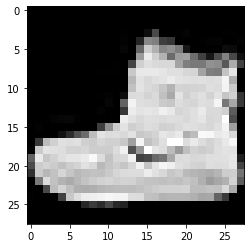

In [48]:
b = next(iter(dl))
xb = b['image']
img = xb[0]
plt.imshow(img[0]);

In [49]:
#| export
@fc.delegates(plt.Axes.imshow)
def show_image(im, ax=None, figsize=None, title=None, noframe=True, **kwargs):
    if fc.hasattrs(im, ('cpu', 'permute', 'detach')):
        im = im.detach().cpu()
        if len(im.shape) == 3 and im.shape[0] < 5:
            im = im.permute(1, 2, 0)
    elif not isinstance(im, np.ndarray):
        im = np.array(im)
    if im.shape[-1] == 1:
        im = im[..., 0]
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None:
        ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    if noframe:
        ax.axis('off')
    return ax

#### `show_image`
- The function is decorated with `@fc.delegates(plt.Axes.imshow)`, which allows it to delegate any unrecognized keyword arguments to the `imshow` function of `plt.Axes`. This means that any addtional keyword arguments passed to will be forwarded to `imshow`.
- Arguments:
    - `im`: The input image, which can be a PIL image or a PyTorch tensor.
    - `ax`: The axes object on which to display the image. If not provided, a new figure and axes will be created.
    - `figsize`: The size of the figure(width, height) in inches. If `ax` is not provided, this argument is used to create a new figure.
    - `title`: The title of the image.
    - `noframe`: A bool indicating whether to hide the frame of the axes.
- The function first checks is `im` has certain attributes (`cpu`, `permute`, `detach`) using `fc.hasattrs`. If it does, it assumes `im` is a PyTorch tensor and performs the following:
    - Detaches the tensor from the computational graph and moves it to the CPU if it was on a GPU.
    - If the tensor has 3 dimensions and the first dimesion is less than 5, it assumes the tensor is in channel-first format and permutes the dimensions to channel-last format.
- If `im` is not a PyTorch tensor, it assumes it is a PIL image or a NumPy array, and if it is not it converts it to one.
- If the lst dimensionof `im` is 1, it removes the last dimension. Useful when working with grayscale images represented as single-channel images.
- If `ax` is not provided, a new figure and axes are created using `plt.subplots` with the specified `figsize`.
- The image is displayed on the axes using `ax.imshow` with the `im` array and any additional arguments passed to `show_image`.
- If `title` is provided, it is set as the title of the axes.
- The x-axis and y-axis ticks are removed.
- If `noframe` is `True`, the frame of the axes is turned off.
- Lastly, the function returns the axes object.

In [50]:
help(show_image)

Help on function show_image in module __main__:

show_image(im, ax=None, figsize=None, title=None, noframe=True, *, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None)
    #| export



<AxesSubplot:>

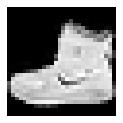

In [51]:
show_image(img, figsize=(2, 2))

<AxesSubplot:>

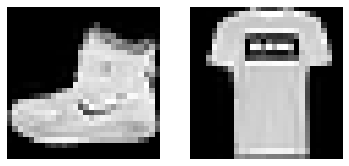

In [52]:
fig, axs = plt.subplots(1, 2)
show_image(img, axs[0])
show_image(xb[1], axs[1])

In [53]:
#| export
@fc.delegates(plt.subplots, keep=True)
def subplots(
    nrows:int=1, # Number of rows in returned axes grid
    ncols:int=1, # Number of columns in returned axes grid
    figsize:tuple=None, # Width, height in inches of the returned figure
    imsize:int=3, # Size (in inches) of images that will be displayed in the returned figure
    suptitle:str=None, # Title to be set to returned figure
    **kwargs
): # fig and axs
    "A figure and set of subplots to display images of `imsize` inches"
    if figsize is None:
        figsize = (ncols * imsize, nrows * imsize)
        fig, ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
        if suptitle is not None:
            fig.suptitle(suptitle)
        if nrows * ncols == 1:
            ax = np.array([ax])
        return fig, ax

#### `subplots`
A utility function that creates a figure and a grid of subplots to display images.
It is decorated with `@fc.delegates(plt.subplots, keep=True)`, which allows it to delegate any unrecognized keyword arguments to the `plt.subplots` function.
- Arguments:
    - `nrows`: Number of rows in the subplot grid
    - `ncols`: Number of columns in the subplot grid
    - `figsize`: The size of the figure (width, height) in inches.If not provided, it will be calculated based on the number of rows, columns and `imsize`.
    - `imsize`: The size (in inches) of the images that will be displayed in the subplot grid.
    - `suptitle`: The title to be set for the entire figure.
    - `**kwargs`
- If `figsize` is not provided, it is calculated based on the `nrows`, `ncols` and `imsize`. The width is `ncols + imsize` and height is `nrows + imsize`.
- `plt.subplots` is called with the specified number of rows, columns, figsize and any additional keyword arguments.
- If `suptitle` if provided, it is set as the title for the entire figure.
- Is the `nrows * ncols == 1`, it means there is only one subplot. In that case, the variabl `ax` is wrapped in a NumPy array to ensure consistency when accessing the axes.
- The function returns the created figure and the axes as a tuple `(fig, ax)`.

In [54]:
from nbdev.showdoc import show_doc

In [55]:
show_doc(subplots)

---

### subplots

>      subplots (nrows:int=1, ncols:int=1, figsize:tuple=None, imsize:int=3,
>                suptitle:str=None, sharex=False, sharey=False, squeeze=True,
>                subplot_kw=None, gridspec_kw=None, **kwargs)

A figure and set of subplots to display images of `imsize` inches

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| nrows | int | 1 | Number of rows in returned axes grid |
| ncols | int | 1 | Number of columns in returned axes grid |
| figsize | tuple | None | Width, height in inches of the returned figure |
| imsize | int | 3 | Size (in inches) of images that will be displayed in the returned figure |
| suptitle | str | None | Title to be set to returned figure |
| sharex | bool | False |  |
| sharey | bool | False |  |
| squeeze | bool | True |  |
| subplot_kw | NoneType | None |  |
| gridspec_kw | NoneType | None |  |
| kwargs |  |  |  |

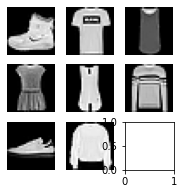

In [56]:
fig, axs = subplots(3, 3, imsize=1)
imgs = xb[:8]
for ax, img in zip(axs.flat, imgs):
    show_image(img, ax)

In [58]:
#| export
@fc.delegates(subplots)
def get_grid(
    n:int, # Number of axes,
    nrows:int=None, # Number of rows, defaulting to `int(math.sqrt(n))`
    ncols:int=None, # Number of columns, defaulting to `ceil(n/rows)`
    title:str=None, # If passed, title set to the figure
    weight:str='bold', # Title font weight
    size:int=14, # Title font size
    **kwargs
): # fig and axs
    "Return a grid of `n` axes, `rows` by `cols`"
    if nrows:
        ncols = ncols or int(np.floor(n / nrows))
    elif ncols:
        nrows = nrows or int(np.ceil(n / ncols))
    else:
        nrows = int(math.sqrt(n))
        ncols = int(np.floor(n / nrows))
    fig, axs = subplots(nrows, ncols, **kwargs)
    for i in range(n, nrows * ncols):
        axs.flat[i].set_axis_off()
    if title is not None:
        fig.suptitle(title, weight=weight, size=size)
    return fig, axs

#### `get_grid`
A utility function that return a grid of axes (subplots) based on the desired number of axes (`n`), `nrows`, `ncols`. It is decorated with `@fc.delegates(subplots)`, which allows it to delegate any unrecognized keyword arguments to `subplots` function.
- Arguments:
    - `n`: Number of axes(subplots) to create.
    - `nrows`: Number of rows in the grid. If not provided, it defaults to `int(math.sqrt(n))`
    - `ncols`: Number of colums. If not provided, it defaults to `ceil(n / rows)`
    - `title`: Title to be set for the entire figure. If provided, it will be set using `fig.suptitle`.
    - `weight`: font weight of the title
    - `size`: font size of the title
    - `**kwargs`
- The `subplots` function is called with `nrows`, `ncols` and any additional arguments. This creates the figure and the grid of subplots.
- If the total number of axes (`n`) is less than `nrows + ncols`, the remaining axes are turned off using `axs.flat[i].set_axis_off()`.
- It `title` is provided, it is set as the title for the entire figure using `fig.suptitle`, with the specified `weight` and `size`.
- The function returns the created figure and the axes as a tuple `(fig, axs)`.

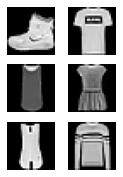

In [59]:
fig, axs = get_grid(8, nrows=3, imsize=1)
for ax, img in zip(axs.flat, imgs):
    show_image(img, ax)

In [65]:
#| export
@fc.delegates(subplots)
def show_images(
    ims:list, # Images to show
    nrows:int|None=None, # Number of rows in grid
    ncols:int|None=None, # Number of columns in grid (auto-calculated if None)
    titles:list|None=None, # Optional list of titles for each image
    **kwargs
):
    "Shwo all images `ims` as subplots with `rows` using `titles`"
    axs = get_grid(len(ims), nrows, ncols, **kwargs)[1].flat
    for im, t, ax in zip_longest(ims, titles or [], axs):
        show_image(im, ax=ax, title=t)

#### `show_images`
A utility function that displays a list of images(`ims`) as subplots in a grid format.
It is decorated with `@fc.delegates(subplots)`, allowing it to delegate any unrecognized keyword arguments to the `subplots` function.
- Arguments:
    - `ims`: list of images to be displayed
    - `nrows`: Number of rows in the grid. If not provided, it will be auto-calculated based on the number of images.
    - `ncols`: Number of columns in the grid. If not provided, it will be auto-calculated based on the number of images.
    - `titles`: optional list of titles for each image
    - `**kwargs`
- `get_grid` function is called with the length of `ims`, `nrows`, `ncols`, and any additional keyword arguments. This returns the figure and axes as a tuple `(fig, axs)`.
- The axes (`axs`) are flattened using `.flat()` method to iterate over them in a linear fashion/
- For each image(`im`), title(`t`), and axis(`ax`) in zipped iteration of `ims`, `titles` and `axs`, the `show_image` function is called with `im` as the images, `ax=ax` as the axis to display the image, and `title=t` as the title for the subplot.

`zip_longest`
- prints the values of iterables alternatively in sequence.
- if one of the iterables is printed fully, the remaining values are filled by the values assigned to `fillvalue` parameter.

In [73]:
a = zip_longest('GesoGes', 'ekfrek', fillvalue='_')
for i in a: print(i)

('G', 'e')
('e', 'k')
('s', 'f')
('o', 'r')
('G', 'e')
('e', 'k')
('s', '_')


In [66]:
yb = b['label']
lbls = yb[:8]

In [67]:
names = 'Top Trouser Pullover Dress Coat Sandal Shirt Sneaker Bag Boot'.split()
titles = itemgetter(*lbls)(names)
' '.join(titles)

'Boot Top Top Dress Top Pullover Sneaker Pullover'

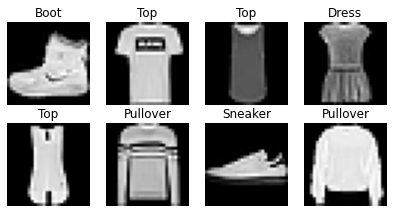

In [68]:
show_images(imgs, imsize=1.7, titles=titles)

In [75]:
#| export
class DataLoaders:
    def __init__(self, *dls): self.train, self.valid = dls[:2]
    
    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        f = collate_dict(dd['train'])
        return cls(*get_dls(*dd.values(), bs=batch_size, collate_fn=f, **kwargs))

#### `DataLoaders`
- Provides a conveniet way to initialize the training and valid data loaders and includes a class method `from_dd` to create `DataLoaders` object from a dictionary of datasets.
- `from_dd` class method is a factory method that creates a `DataLoaders` object from adict of datasets(`dd`). It takes the following arguments:
    - `dd`: dict of datasets,
    - `batch_size`: batch size to use for the data loaders
    - `as_tuple`: bool flag indicating whether to return the data loaders as tuple
    - `**kwargs`
- Inside `from_dd` method, `collate_dict` function is used to create a collate function `f` from the `train` dataset in the dict.
- `get_dls` function is then called with the values of the dataset dict (`*dd.values()`) along with the batch size (`bs`), the collate function (`collate_fn=f`), and any additional keyword arguments. This returns the training and valid data loaders.
- Finally, a new instance of the `DataLoaders` class is created using the obtained data loaders, and it is returned as a tuple or seperate arguments based on the value of `as_tuple`.

## Export

In [77]:
import nbdev
nbdev.nbdev_export()

JSONDecodeError: Expecting value: line 1 column 1 (char 0)